# Kernel regression

<a target="_blank" href="https://colab.research.google.com/github/GaiaSaveri/intro-to-ml/blob/main/solved-notebooks/SOLVED-Lab-9.Kernel_Regression.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from math import sin
from math import cos

## Linear data

First, we need some data we can play with. Let's create some arbitrary 2D samples.

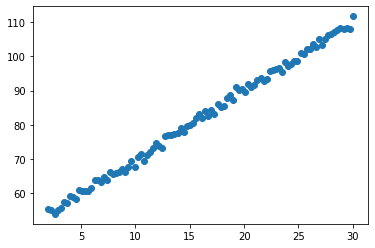

In [ ]:
points = 100
sigma = 1

eps = np.random.normal(0,sigma,points)
x = np.linspace(2,30,points)
y = 2 * x + 50 + eps
x = x[:, np.newaxis]
plt.plot(x,y, 'o')

You can clearly see that there is a strong correlation between the two variables.

We know that the equation of a line is $y = wx$. Solving for $w$: $$w = X^{-1}y$$

Since we can not invert a matrix that isn’t square we simply make $X$ square by multiplying with its own transpose before inversion. To get the original shape back and by magic of math we multiply by the transpose again.
$$X^{-1} \sim (X^TX)^{-1} \, X^T$$
Plugging it in:
$$w=(X^{T}X)^{-1}\, X^{T} \, y$$

Dimensions: 
- $X\in R^{N\times d}$
- $X^{T}X\in R^{d\times d}$  

where $N$ is the number of points and $d$ is the dimension of each point.

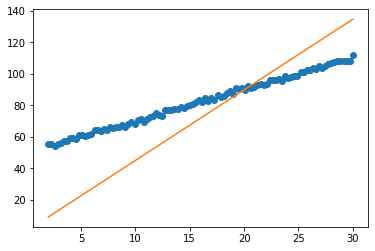

In [ ]:
k = np.linalg.inv(np.dot(x.T, x))
w = np.dot(k, np.dot(x.T,y))
plt.plot(x,y,'o')
plt.plot(x, w*x)

Well we got a line, but it doesn’t really match the data yet. So what went wrong? The line equation that we started with $y=wx$ will always pass through $(0,0)$.

However, the regression line we expect from our data does not pass through $(0,0)$. So we have to adjust our line equation so that it’s y-value at $x=0$ can be fitted by our approach. We all know that we can simply add a constant to our line formula to end up with $y=wx+b$.

To deal with this situation, we just add an extra dimension to our data. Now the same multiplication of $X$ and $w$ will be $2$ dimensional as well. The matrix multiplication looks like this:

$$ \begin{bmatrix}
x_{0,0} \, w_0 + x_{0,1} \, w_1\\
\dots \\
x_{0,0} \, w_0 + x_{n,1} \, w_1
\end{bmatrix} = \begin{bmatrix}
y_0 \\ \dots \\ y_n
\end{bmatrix}
$$

Now if we set $x[:,1] = 1$ and we view $w[1]$ as $b$, we get the line equation with our bias. We don't even have to change our equations!

1. **Redo the calculations to add the constant $b$, then plot it.**  
*Tip: have a look at ```np.stack()```*

In [ ]:
# before
x[:5]

array([[2.        ],
       [2.28282828],
       [2.56565657],
       [2.84848485],
       [3.13131313]])

In [ ]:
# np.stack: join a sequence of arrays along a new axis
x = np.stack([x[:,0], np.ones(x.shape[0])], axis=1).reshape(-1,2)
k = np.linalg.inv(np.dot(x.T,x))
w = np.dot(k,np.dot(x.T,y))

In [ ]:
# after
x[:5]

array([[2.        , 1.        ],
       [2.28282828, 1.        ],
       [2.56565657, 1.        ],
       [2.84848485, 1.        ],
       [3.13131313, 1.        ]])

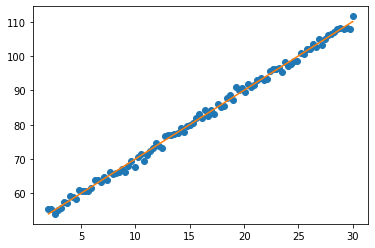

In [ ]:
plt.plot(x[:,0], y, 'o')
plt.plot(x[:,0], x[:,0]*w[0] + w[1])

###Ridge regression
Sometimes the pseudo-inverse can run into trouble which can be avoided if we add a small value to our matrix before computing the inverse. This is known as *ridge regression*.


$$
w=(X^{T}X+\lambda \, I)^{-1}\, X^{T}y
$$



In [ ]:
lam = 1
k = np.linalg.inv(np.dot(x.T,x) + lam * np.eye(x.shape[1]))
w_ridge = np.dot(k,np.dot(x.T,y))

## Kernel Regression

What if our data isn't linear?  
If we add a few dimensions to our input data we might be able to a linear regression in the higher dimension (feature space).

Let's set up some non-linear data.

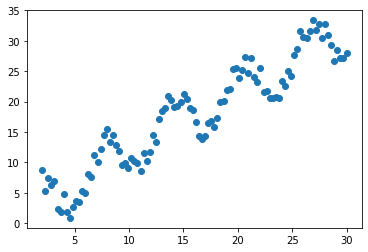

In [ ]:
y = x[:,0] + 4 * np.sin(x[:,0])+ 4 * np.random.rand(x.shape[0])

plt.plot(x[:,0], y, 'o')

2. **Define the following kernel functions**
- Polynomial $$k(x_1,x_2) = (x_1^T \cdot x_2 +1 )^p $$
- Gaussian $$k(x_1, x_2) = \exp \bigg( - \frac{||x_1-x_2||^2}{2p^2} \bigg)$$
- Linear $$k(x_1,x_2) = x_1^T \cdot x_2 $$

**then calculate the kernel matrix $K$.**

In [ ]:
def kernelFunc(x1, x2, kernel_type, param):
    
    if kernel_type == 'Polynomial':
        return pow((1 + np.dot(x1, x2)), param)
    
    elif kernel_type == 'Gaussian':
        return np.exp(-(np.dot(x1-x2,x1-x2) /param**2))
    
    # Linear Kernel, same as not using Kernels at all
    elif kernel_type == 'Linear':
        return np.dot(x1,x2)

In [ ]:
kernel_type = 'Gaussian'
param = 1


# We could just call the kernel function every time, instead we store the solutions in this matrix to save some computations
K = np.zeros((x.shape[0], x.shape[0]))

for i, row in enumerate(K):
    for j, col in enumerate(K.T):
        K[i,j] = kernelFunc(x[i,:], x[j,:], kernel_type, param)

Before going on, notice how $$w = (X^TX + \lambda I )^{-1} X^Ty$$ is the same as $$w=X^T(XX^T  + \lambda I)^{-1}y.$$ By changing the order of the transpose, we can compute the inverse just as well.

Now we just take our linear regression and replace all dot products with kernel functions.

$$
y(z)=z^Tw=z^T \, X^{T}(XX^{T})^{-1} \, y = \alpha(z) \, K^{-1} \, y
$$

with $$\alpha(z)= \begin{bmatrix}
k(z,x_0) \\ \dots \\ k(z,x_N) 
\end{bmatrix} \in R^{1\times N} $$

The Kernel matrix here is $K=XX^{T}\in R^{N\times N}$, where $N$ is the number of points.

Notice that we also have to embed the vector at which we evaluate the regression, here $z$. Putting this into code we get:


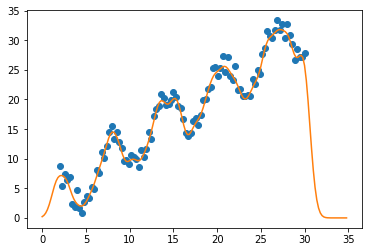

In [ ]:
# calculate the inverse of K with ridge regression, then the weights
a = np.linalg.inv(K + 0.1 * np.eye(K.shape[0]))
w = np.dot(y,a)

x_pred = np.arange(0, 35, 0.2)
# same as before, add column of ones to represent the constant b
x_pred = np.stack([x_pred, np.ones(x_pred.shape[0])], axis=1).reshape(-1,2)
y_pred = np.zeros(x_pred.shape[0])

for i, x_p in enumerate(x_pred):
    k = np.zeros(x.shape[0])
    for j, row in enumerate(k):
        k[j] = kernelFunc(x_p, x[j,:], kernel_type, param)
    y_pred[i] = np.dot(w,k)

plt.plot(x[:,0], y, 'o')
plt.plot(x_pred[:,0], y_pred)

## Putting all together

This function performs Kernel Ridge Regression (KRR) from scratch (S) on a given training dataset and uses the resulting model to predict the labels of a given test dataset.

The inputs to the function are:

- X_train: a numpy array representing the training data.
- y_train: a numpy array representing the target variable for the training data.
- X_test: a numpy array representing the test data.
- kernel_type: a string indicating the type of kernel to be used. 
- param: the parameter to be used in the kernel function.
- lam: a scalar indicating the regularization parameter for the KRR model.

The function first computes the kernel matrix $K$ using the training data and the kernel function specified by kernel_type and param. It then applies ridge regression to the kernel matrix to calculate the weights. Finally, it computes the predicted target values for the test data using the kernel function and the learned weights. The predicted labels are returned as an array.

3. **Write this function.**

In [ ]:
def KRRS(X_train, y_train, X_test, kernel_type, param, lam):
    
    # compute kernel matrix
    K = np.zeros((X_train.shape[0], X_train.shape[0]))
   
    for i, row in enumerate(K):
      for j, col in enumerate(K.T):
          K[i,j] = kernelFunc(X_train[i,:], X_train[j,:], kernel_type, param)

    # calculate the inverse of K with ridge regression, then the weights
    a = np.linalg.inv(K + lam * np.eye(K.shape[0]))
    w = np.dot(a, y_train) 

    # compute the predicted labels
    y_pred = np.zeros((X_test.shape[0])) 
 
    for i, x_p in enumerate(X_test):
      k = np.zeros(X_test.shape[0])
      for j, row in enumerate(k):
          k[j] = kernelFunc(x_p, X_test[j,:], kernel_type, param)
      y_pred[i] = np.dot(k, w)

    return y_pred

In [ ]:
X_train = np.linspace(2,30,100)
X_train = X_train[:, np.newaxis]
X_train = np.stack([X_train[:,0], np.ones(X_train.shape[0])], axis=1).reshape(-1,2)
y_train = X_train[:,0] + 4 * np.sin(X_train[:,0])+ 4 * np.random.rand(X_train.shape[0])

X_test = np.arange(2, 30, 0.2)
# same as before, add column of ones to represent the constant b
X_test = np.stack([X_test, np.ones(X_test.shape[0])], axis=1).reshape(-1,2)
y_test = X_test[:,0] + 4 * np.sin(X_test[:,0])+ 4 * np.random.rand(X_test.shape[0])

y_pred = KRRS(X_train, y_train, X_test, 'Gaussian', 1, 0.1)

ValueError: ignored

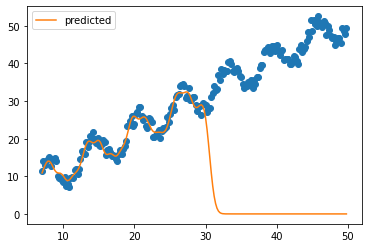

In [ ]:
plt.plot(X_test[:,0], y_test, 'o')
plt.plot(X_test[:,0], y_pred, label = 'predicted')
plt.legend()

### Pre-made functions for KRR
- always [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)

In [ ]:
from sklearn.kernel_ridge import KernelRidge

n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
krr = KernelRidge(alpha=1.0, kernel = 'rbf') # other options: linear, polynomial, exponential, laplacian, chi2, sigmoid
krr.fit(x_pred, y_pred)

KernelRidge(alpha=1.0, kernel='rbf')